## RNN LSTM을 이용한 DJI 주가 예측

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-8) # --- 0으로 나누는 오류를 예방하기 위함

# 데이터 내의 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 
# x(주가)를 최소값과 최대값을 이용하여 0~1 사이의 값으로 변환시켜 분석에 사용한다

def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

# scale된 값을 다시 원래의 값으로 되돌리기 위한 함수
# scaling하기 이전의 orginal x값과 되돌리고 싶은 x를 입력하면 다시 unscaling된 값으로 리턴한다
# 학습에서 추정 이후 원래의 주가로 다시 변환하여 확인하기 위한 용도

### 0-2. 하이퍼파라미터 설정

In [3]:
n_in = 6                   # input의 column 개수 (Feature(또는 Variable) 개수)
n_out = 1                  # output의 column 개수 (하나의 주가 출력)
 
seq_length = 28            # 1개 시퀀스의 길이 (시계열 데이터 입력 개수)
n_hidden = 20              # 각 셀의 (hidden) 출력 크기
forget_bias = 1.0          # 망각편향 (기본값 1.0)
 
epochs = 500               # 총 학습 반복횟수
learning_rate = 0.01       # optimizer의 학습률

In [12]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다

X = tf.placeholder(tf.float32, [None, seq_length, n_in]) # [None, 28, 6]                                                           
Y = tf.placeholder(tf.float32, [None, n_out])                                        
n_batch = tf.placeholder(tf.int32, [])

# 검증용 측정지표(RMSE)를 산출하기 위해 targets, predictions를 생성한다
# batch size에 상관없이 유동적으로 계산할 수 있음
# targets에는 y의 실제 값, predictions에는 학습을 통해 예측된 값을 feed
# RMSE = sqrt (targets - predictions)^2

targets = tf.placeholder(tf.float32, [None, n_out])
predictions = tf.placeholder(tf.float32, [None, n_out])

In [13]:
# LSTM 네트워크 생성
def inference():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = n_hidden,       # cell의 차원은 [n_batch, n_hidden]
                                        forget_bias = forget_bias,  # (망각편향)
                                        state_is_tuple = True,      # c-state와 a-state를 tuple의 형태로 출력
                                        activation = tf.tanh)  

    init_state = cell.zero_state(n_batch, tf.float32)               # cell의 모든 값을 0으로 초기화
    state = init_state

    outputs = []
    with tf.variable_scope("LSTM"):                                 
        for t in range(seq_length):
            if t > 0:
                tf.get_variable_scope().reuse_variables()           # with문 안에서 이미 존재하는 변수들을 다시 가져와 사용

            (cell_output, state) = cell(X[:, t, :], state)          # t마다 cell_output = y_hat(t), state = a(t)를 
            outputs.append(cell_output)                             # 다음 시점으로 output

        output = outputs[-1]                                        # 1,...,28시점의 x로 추정한 29번째 y_hat

        W = tf.Variable(tf.truncated_normal([n_hidden, n_out], stddev = 0.01))
        b = tf.Variable(tf.zeros([n_out]))

        y = tf.matmul(output, W) + b                                # 최종 linear y_hat
        return y

In [14]:
hypothesis = inference()

loss = tf.reduce_mean(tf.square(hypothesis - Y))                    # 손실함수로 평균제곱오차(MSE)를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)                   # 최적화함수로 AdamOptimizer를 사용한다
train_step = optimizer.minimize(loss)
 
# RMSE (Root Mean Square Error)
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))    # 즉 평균 절댓값오차

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


### 3. 학습 ***

In [15]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
n_batches = N_train // batch_size     # 학습 1회마다 9번의 mini-batch

from sklearn.utils import shuffle

my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(trainX, trainY)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict = { X: X_[start:end], Y: Y_[start:end], n_batch: batch_size })
        val_loss = sess.run(loss, feed_dict = { X: X_[start:end], Y: Y_[start:end], n_batch: batch_size })
        my_loss.append(val_loss)
        
        if epoch % 10 == 0:
            print("epoch:" , epoch, ", current loss:", val_loss)

epoch: 0 , current loss: 0.17657322
epoch: 0 , current loss: 0.13028906
epoch: 0 , current loss: 0.054683227
epoch: 0 , current loss: 0.036317248
epoch: 0 , current loss: 0.028465992
epoch: 0 , current loss: 0.04917818
epoch: 0 , current loss: 0.052669574
epoch: 0 , current loss: 0.04686624
epoch: 0 , current loss: 0.03778369
epoch: 10 , current loss: 0.00015523151
epoch: 10 , current loss: 0.00016744998
epoch: 10 , current loss: 0.0002539865
epoch: 10 , current loss: 0.00030275516
epoch: 10 , current loss: 0.0003514488
epoch: 10 , current loss: 0.00028088025
epoch: 10 , current loss: 0.00013199747
epoch: 10 , current loss: 0.00016680128
epoch: 10 , current loss: 0.00023062793
epoch: 20 , current loss: 0.00016158205
epoch: 20 , current loss: 0.0002111062
epoch: 20 , current loss: 0.00019038403
epoch: 20 , current loss: 0.0002563028
epoch: 20 , current loss: 0.00025368936
epoch: 20 , current loss: 0.00026141808
epoch: 20 , current loss: 0.00017477035
epoch: 20 , current loss: 0.00017469

epoch: 230 , current loss: 0.000114097864
epoch: 230 , current loss: 9.8260876e-05
epoch: 230 , current loss: 0.00011607456
epoch: 230 , current loss: 0.00013007136
epoch: 230 , current loss: 0.00015010472
epoch: 230 , current loss: 0.000103388615
epoch: 230 , current loss: 0.0001640852
epoch: 230 , current loss: 0.00011440026
epoch: 230 , current loss: 0.00022647377
epoch: 240 , current loss: 0.00013872865
epoch: 240 , current loss: 0.00013154146
epoch: 240 , current loss: 0.00011101109
epoch: 240 , current loss: 0.00011202443
epoch: 240 , current loss: 0.000116901894
epoch: 240 , current loss: 9.866886e-05
epoch: 240 , current loss: 0.00014228122
epoch: 240 , current loss: 0.0001052135
epoch: 240 , current loss: 9.806568e-05
epoch: 250 , current loss: 8.736602e-05
epoch: 250 , current loss: 0.0001254366
epoch: 250 , current loss: 0.000116269075
epoch: 250 , current loss: 0.00011696518
epoch: 250 , current loss: 0.00011322597
epoch: 250 , current loss: 0.00010143798
epoch: 250 , curre

epoch: 460 , current loss: 7.989416e-05
epoch: 460 , current loss: 0.0001213696
epoch: 460 , current loss: 0.0001337402
epoch: 460 , current loss: 0.000111066314
epoch: 460 , current loss: 0.0001112907
epoch: 460 , current loss: 0.00013456453
epoch: 460 , current loss: 0.00010788062
epoch: 460 , current loss: 0.00013436658
epoch: 460 , current loss: 0.000100617275
epoch: 470 , current loss: 8.920661e-05
epoch: 470 , current loss: 0.00014170475
epoch: 470 , current loss: 0.00010550507
epoch: 470 , current loss: 0.00013425322
epoch: 470 , current loss: 0.000121631194
epoch: 470 , current loss: 0.00011797363
epoch: 470 , current loss: 0.00014454575
epoch: 470 , current loss: 9.971853e-05
epoch: 470 , current loss: 0.00014314544
epoch: 480 , current loss: 9.0432026e-05
epoch: 480 , current loss: 0.00012425752
epoch: 480 , current loss: 9.803431e-05
epoch: 480 , current loss: 0.00010222645
epoch: 480 , current loss: 0.0001356092
epoch: 480 , current loss: 7.4552234e-05
epoch: 480 , current 

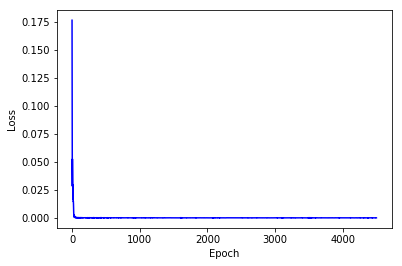

In [24]:
plt.plot(my_loss, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 4. 완료된 모형의 예측력 평가

### 4-1. 학습 데이터와 테스트 데이터의 RMSE 비교

In [17]:
# train과 test의 각각 예측된 y_hat
train_predict = hypothesis.eval(session = sess, feed_dict = { X: trainX, n_batch: trainX.shape[0] })
test_predict = hypothesis.eval(session = sess, feed_dict = { X: testX, n_batch: testX.shape[0] })

In [18]:
# train과 test의 RMSE
train_rmse = rmse.eval(session = sess, feed_dict = { targets: trainY, predictions: train_predict })
test_rmse = rmse.eval(session = sess, feed_dict = { targets: testY, predictions: test_predict })
print("Train RMSE:", train_rmse, "Test RMSE:", test_rmse)

Train RMSE: 0.010313703 Test RMSE: 0.011190885
